## HousePrices Kaggle

## 分析流程

### 1.資料匯入
- 匯入套件 
- 讀取資料
### 2.資料確認
- 檢查有無遺失值，補入遺失值
- 資料檢視
- 有無離群值
### 3.變數工程
- 新增變數
- 調整連續行變數尺規
- 平滑預測變數
- 類別行變數調整為dummy variable
### 4.變數檢視
- 關聯性
- IV
- 分群
### 5.建模
- xgboost
- svm
- 類神經
- ML ...
### 6. Stacking
- ensemble



### 1.資料匯入
- 匯入套件

In [0]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn import preprocessing

#小數點取到第三位
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 


### 1.資料匯入
- 讀取資料

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#train.head()
#test.head()
train['flag'] ='train'
test['flag'] ='test'
fulldata = pd.concat((train, test)).reset_index(drop=True) 
#fulldata.head()
#看資料筆數
print(len(fulldata),len(train),len(test))

2919 1460 1459


In [0]:
#取出類別行變數與連續行變數
category_var = fulldata.select_dtypes(['object']).columns 
conti_var = fulldata.select_dtypes(exclude=['object']).columns 
#category_var
#conti_var
#檢查有無交集，空集合是對的
category_var.intersection(conti_var )

Index([], dtype='object')

### 資料確認
- 檢查遺失值

In [0]:
#concat(物件，axis=1 => 直的排，keys=物件源)
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs['Total'] = len(fulldata)
NAs['Missing sum'] = NAs['Train'] + NAs['Test']
NAs['Missing percent'] = NAs['Missing sum'] / NAs['Total']
#挑出有NA的欄位
NAs[NAs['Missing sum']> 0]

,Train,Test,Total,Missing sum,Missing percent
Alley,1369,1352.000,2919,2721.000,0.932
BsmtCond,37,45.000,2919,82.000,0.028
BsmtExposure,38,44.000,2919,82.000,0.028
BsmtFinSF1,0,1.000,2919,1.000,0.000
BsmtFinSF2,0,1.000,2919,1.000,0.000
BsmtFinType1,37,42.000,2919,79.000,0.027
BsmtFinType2,38,42.000,2919,80.000,0.027
BsmtFullBath,0,2.000,2919,2.000,0.001
BsmtHalfBath,0,2.000,2919,2.000,0.001
BsmtQual,37,44.000,2919,81.000,0.028


### 2.資料確認
- 補入遺失值

In [0]:
#取出類別型遺失值<5的欄位
m1 = NAs[(NAs['Missing sum']>0) & (NAs['Missing sum']<5)].index
for col in category_var.intersection(m1):
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna(fulldata[col].value_counts().keys()[0], inplace=True)
    print(col +'遺失值補' + fulldata[col].value_counts().keys()[0])

Electrical遺失值補SBrkr
Exterior1st遺失值補VinylSd
Exterior2nd遺失值補VinylSd
Functional遺失值補Typ
KitchenQual遺失值補TA
MSZoning遺失值補RL
SaleType遺失值補WD
Utilities遺失值補AllPub


In [0]:
#取出連續型遺失值<5的欄位
m2 = NAs[(NAs['Missing sum']>0) & (NAs['Missing sum']<5)].index
for col in conti_var.intersection(m2):
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna(0, inplace=True)
    print(col +'遺失值補' + '0')

BsmtFinSF1遺失值補0
BsmtFinSF2遺失值補0
BsmtFullBath遺失值補0
BsmtHalfBath遺失值補0
BsmtUnfSF遺失值補0
GarageArea遺失值補0
GarageCars遺失值補0
TotalBsmtSF遺失值補0


In [0]:
NAs = pd.concat([fulldata[fulldata['flag']=='train'].isnull().sum(), fulldata[fulldata['flag']=='test'].isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs['Total'] = len(fulldata)
NAs['Missing sum'] = NAs['Train'] + NAs['Test']
NAs['Missing percent'] = NAs['Missing sum'] / NAs['Total']
#挑出有NA的欄位
NAs[NAs['Missing sum']> 0]

,Train,Test,Total,Missing sum,Missing percent
Alley,1369,1352,2919,2721,0.932
BsmtCond,37,45,2919,82,0.028
BsmtExposure,38,44,2919,82,0.028
BsmtFinType1,37,42,2919,79,0.027
BsmtFinType2,38,42,2919,80,0.027
BsmtQual,37,44,2919,81,0.028
Fence,1179,1169,2919,2348,0.804
FireplaceQu,690,730,2919,1420,0.486
GarageCond,81,78,2919,159,0.054
GarageFinish,81,78,2919,159,0.054


- 補入遺失值
#### BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 BsmtQual
#### GarageCond GarageFinish GarageQual GarageType GarageYrBlt 
#### MasVnrArea MasVnrType 
#### Fence FireplaceQu PoolQC Alley MiscFeature

In [0]:
#挑出Bsm系列變數觀察遺失值狀況，發現BsmtCond為空，其他皆為空，判斷為皆無地下室，填寫None
b = fulldata[['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual']]
#b[fulldata['BsmtCond'].isnull()]

In [0]:
for col in ['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual']:
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna('None', inplace=True)
    print(col +'遺失值補' + 'None')

BsmtCond遺失值補None
BsmtExposure遺失值補None
BsmtFinType1遺失值補None
BsmtFinType2遺失值補None
BsmtQual遺失值補None


In [0]:
#挑出Garage系列變數觀察遺失值狀況，發現GarageCond為空，其他皆為空，判斷無車庫，填寫None
g = fulldata[['GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']]
#g[fulldata['GarageCond'].isnull()]

In [0]:
for col in ['GarageCond','GarageFinish','GarageQual','GarageType']:
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna('None', inplace=True)
    print(col +'遺失值補' + 'None')

fulldata['GarageYrBlt'].fillna(0, inplace=True)

GarageCond遺失值補None
GarageFinish遺失值補None
GarageQual遺失值補None
GarageType遺失值補None


In [0]:
#MasVnrArea=0 則 MasVnrType為NA
m = fulldata[['MasVnrArea','MasVnrType']]
#m[fulldata['MasVnrArea'].isnull()]
fulldata['MasVnrType'].fillna('None', inplace=True)
fulldata['MasVnrArea'].fillna(0, inplace=True)

In [0]:
# Fence FireplaceQu PoolQC Alley PoolQC為空判斷為無此項設施
for col in ['Fence', 'FireplaceQu', 'PoolQC' ,'Alley' ,'MiscFeature']:
    #print (col,fulldata[col].value_counts())
    fulldata[col].fillna('None', inplace=True)
    print(col +'遺失值補' + 'None')
    

Fence遺失值補None
FireplaceQu遺失值補None
PoolQC遺失值補None
Alley遺失值補None
MiscFeature遺失值補None


- 補入遺失值
#### LotFrontage 用隨機森林補值

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

def imputeMissing(df, idx, predictors):
    tempdf = df[df[outcome].isnull()].index
    tempndf = df[df[idx].notnull()].index
    model = RandomForestRegressor(n_estimators=100) 
    model.fit(df.loc[tempndf, predictors], df.loc[tempndf, [outcome]]) 
    predict = model.predict(df.loc[tempndf, predictors])
    j=0;
    for i in tempdf:
        df.loc[i,outcome] = predict[j]
        j=j+1 
    return(df)

predictors=['LotArea','Street','LotShape','LandContour','LotConfig']
outcome='LotFrontage'

var_mod = ['Street','LotShape','LandContour','LotConfig']

le = LabelEncoder()
for i in var_mod:
    fulldata[i] = le.fit_transform(fulldata[i].astype(str))
fulldata[var_mod].head(5)

/Users/YiHsien/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,Street,LotShape,LandContour,LotConfig
0,1,3,3,4
1,1,3,3,2
2,1,0,3,4
3,1,0,3,0
4,1,0,3,2


In [0]:
#使用隨機森林預測遺失值
predictors=['LotArea','Street','LotShape','LandContour','LotConfig'] 
outcome='LotFrontage'
var_mod = ['Street','LotShape','LandContour','LotConfig'] 
le = LabelEncoder()

for i in var_mod:
    fulldata[i] = le.fit_transform(fulldata[i].astype(str))
    fulldata = imputeMissing(fulldata,outcome,predictors) 

fulldata['LotFrontage'].isnull().sum()


/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0

#### 確認是否已完成遺失值補值

In [0]:
NAs = pd.concat([fulldata[fulldata['flag']=='train'].isnull().sum(), fulldata[fulldata['flag']=='test'].isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs['Total'] = len(fulldata)
NAs['Missing sum'] = NAs['Train'] + NAs['Test']
NAs['Missing percent'] = NAs['Missing sum'] / NAs['Total']
#挑出有NA的欄位
NAs[NAs['Missing sum']> 0]

,Train,Test,Total,Missing sum,Missing percent
SalePrice,0,1459,2919,1459,0.500


## 2.資料確認
- 資料檢視

### 資料觀察 MSSubClass YrSold MoSold YearBuilt GarageYrBlt

In [0]:
import pandas as pd
pd.set_option('display.max_columns',200)
fulldata[conti_var].describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,Id,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,1460.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000,2919.000
mean,1159.582,336.484,2.602,2.860,441.272,49.565,0.430,0.061,560.580,23.098,0.597,1.568,472.713,1.766,1870.364,1500.760,0.380,1460.000,1.045,10168.114,69.505,4.694,57.138,101.396,50.826,6.213,47.487,5.565,6.089,2.252,180921.196,16.062,6.452,1051.417,93.710,1971.313,1984.264,2007.793
std,392.362,428.701,25.188,0.823,455.606,169.179,0.525,0.246,439.591,64.244,0.646,0.553,215.536,0.762,449.686,506.051,0.503,842.787,0.214,7886.996,22.860,46.397,42.518,178.855,567.402,2.715,67.575,1.113,1.410,35.664,79442.503,56.184,1.569,441.120,126.527,30.291,20.894,1.315
min,334.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,1.000,0.000,1300.000,21.000,0.000,20.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,34900.000,0.000,2.000,0.000,0.000,1872.000,1950.000,2006.000
25%,876.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,220.000,0.000,0.000,1.000,320.000,1.000,1957.000,1126.000,0.000,730.500,1.000,7478.000,59.000,0.000,20.000,0.000,0.000,4.000,0.000,5.000,5.000,0.000,129975.000,0.000,5.000,793.000,0.000,1953.500,1965.000,2007.000
50%,1082.000,0.000,0.000,3.000,368.000,0.000,0.000,0.000,467.000,0.000,1.000,2.000,480.000,2.000,1977.000,1444.000,0.000,1460.000,1.000,9453.000,68.628,0.000,50.000,0.000,0.000,6.000,26.000,5.000,6.000,0.000,163000.000,0.000,6.000,989.000,0.000,1973.000,1993.000,2008.000
75%,1387.500,704.000,0.000,3.000,733.000,0.000,1.000,0.000,805.000,0.000,1.000,2.000,576.000,2.000,2001.000,1743.500,1.000,2189.500,1.000,11570.000,80.000,0.000,70.000,163.500,0.000,8.000,70.000,6.000,7.000,0.000,214000.000,0.000,7.000,1302.000,168.000,2001.000,2004.000,2009.000
max,5095.000,2065.000,508.000,8.000,5644.000,1526.000,3.000,2.000,2336.000,1012.000,4.000,4.000,1488.000,5.000,2207.000,5642.000,2.000,2919.000,3.000,215245.000,313.000,1064.000,190.000,1600.000,17000.000,12.000,742.000,9.000,10.000,800.000,755000.000,576.000,15.000,6110.000,1424.000,2010.000,2010.000,2010.000


In [0]:
print(fulldata['GarageYrBlt'].describe())
fulldata[fulldata['GarageYrBlt']>2100]
fulldata.loc[2592, 'GarageYrBlt'] = 2007

count   2919.000
mean    1870.364
std      449.686
min        0.000
25%     1957.000
50%     1977.000
75%     2001.000
max     2207.000
Name: GarageYrBlt, dtype: float64


In [0]:
# MSSubClass YrSold MoSold YearBuilt 為類別型資料
#MSSubClass
fulldata['MSSubClass'] = fulldata['MSSubClass'].apply(str)

#Year month
fulldata['YrSold_char'] = fulldata['YrSold'].astype(str)
fulldata['MoSold_char'] = fulldata['MoSold'].astype(str)
fulldata['YearBuilt_char'] = fulldata['YearBuilt'].astype(str)

### 檢查類別行資料分布

In [0]:
char = fulldata[category_var].apply(lambda x: len(np.unique(x)))
char.sort_values(ascending=False)

YearBuilt_char    118
Neighborhood       25
MSSubClass         16
Exterior2nd        16
Exterior1st        15
MoSold_char        12
Condition1          9
SaleType            9
Condition2          8
HouseStyle          8
RoofMatl            7
BsmtFinType2        7
Functional          7
BsmtFinType1        7
GarageType          7
Heating             6
FireplaceQu         6
Foundation          6
GarageCond          6
GarageQual          6
RoofStyle           6
SaleCondition       6
HeatingQC           5
BldgType            5
BsmtCond            5
BsmtExposure        5
YrSold_char         5
BsmtQual            5
Electrical          5
ExterCond           5
Fence               5
MiscFeature         5
MSZoning            5
PoolQC              4
ExterQual           4
KitchenQual         4
MasVnrType          4
GarageFinish        4
PavedDrive          3
LandSlope           3
Alley               3
Utilities           2
CentralAir          2
flag                2
dtype: int64

In [0]:
# Utilities CentralAir 類別較少，進行確認，Utilities皆為同一值對分析無幫助，故刪除
print(fulldata['Utilities'].value_counts())
print(fulldata['CentralAir'].value_counts()) 
fulldata = fulldata.drop('Utilities', axis=1)

AllPub    2915
NoSeWa       1
Name: Utilities, dtype: int64
Y    2720
N     196
Name: CentralAir, dtype: int64


### 2.資料確認
- 移除離群值

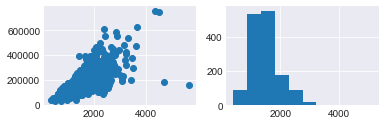

In [0]:
#確認 GrLivArea房價過低，測試集也無GrLivArea 4500之資料，故刪除
plt.subplot(221)
plt.scatter(train.GrLivArea, train.SalePrice)
plt.subplot(222)
plt.hist(test.GrLivArea)
plt.show()

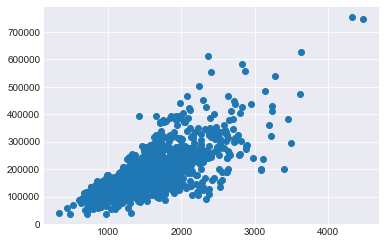

In [0]:
fulldata = fulldata[fulldata.GrLivArea < 4500]
plt.scatter(fulldata.GrLivArea, fulldata.SalePrice)

### 3.變數工程
- 創造新變數

In [0]:
#房子蓋好後多久售出
fulldata['yeardiff'] = fulldata['YrSold'] - fulldata['YearBuilt']
#房子蓋好後多久裝潢
fulldata['yeardiffremod'] = fulldata['YearRemodAdd'] - fulldata['YearBuilt']
#裝潢後多久售出
fulldata['yearremoddiff'] = fulldata['YrSold'] - fulldata['YearRemodAdd']

#總面積
fulldata['allarea'] = (fulldata['LotArea'] + fulldata['MasVnrArea'] + fulldata['BsmtFinSF1'] + 
                      fulldata['BsmtFinSF2'] + fulldata['BsmtUnfSF'] + fulldata['TotalBsmtSF'] + 
                      fulldata['1stFlrSF'] + fulldata['2ndFlrSF'] + fulldata['LowQualFinSF'] + 
                      fulldata['GrLivArea'] + fulldata['GarageArea'] + fulldata['WoodDeckSF'] + 
                      fulldata['OpenPorchSF'] + fulldata['EnclosedPorch'] + fulldata['3SsnPorch'] + 
                      fulldata['ScreenPorch'] +fulldata['PoolArea'])
#主要面積
fulldata['mainarea'] = fulldata['TotalBsmtSF'] +fulldata['1stFlrSF'] + fulldata['2ndFlrSF']
#其他面積
fulldata['elsearea'] = fulldata['allarea'] - fulldata['mainarea'] 

#計算品質次數 Ex>Gd>TA>Fa>Po>None 5=>4=>3=>2=>1
qual = fulldata[['HeatingQC','KitchenQual','FireplaceQu','GarageQual','PoolQC','ExterQual','BsmtQual']]

for col in ['HeatingQC','KitchenQual','FireplaceQu','GarageQual','PoolQC','ExterQual','BsmtQual']:
    print(col)
    conditions = [
        (qual[col] == 'Ex'),
        (qual[col] == 'Gd'),
        (qual[col] == 'TA'),
        (qual[col] == 'Fa'),
        (qual[col] == 'Po'),
        (qual[col] == 'None')
    ]
    choices = [5,4,3,2,1,0]
    qual[col] = np.select(conditions, choices,default=999)

fulldata['qc_score'] = qual.sum(axis = 1)

HeatingQC
KitchenQual
FireplaceQu
GarageQual
PoolQC
ExterQual


/Users/YiHsien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


BsmtQual


### 3.變數工程 
- 平滑預測變數：房價取log

/Users/YiHsien/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


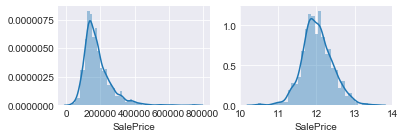

In [0]:
plt.subplot(221)
ax = sns.distplot(train['SalePrice'])
plt.subplot(222)
ax = sns.distplot(np.log(train['SalePrice']))

In [0]:
fulldata['SalePrice'] = np.log(fulldata['SalePrice'])

### 3.變數工程 
- 調整連續行變數尺規

In [0]:

#重新取出類別行變數與連續行變數
category_var = fulldata.select_dtypes(['object']).columns 
conti_var = fulldata.select_dtypes(exclude=['object']).columns 


# Check the skew of all numerical features
skewed_feats = fulldata[conti_var].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,22.179
PoolArea,17.686
LotArea,13.188
LowQualFinSF,12.082
elsearea,11.779
3SsnPorch,11.370
allarea,10.708
KitchenAbvGr,4.300
BsmtFinSF2,4.144
EnclosedPorch,4.002


In [0]:
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
skew_index = skewness.index

for col in skew_index:
    fulldata[col]= boxcox1p(fulldata[col], boxcox_normmax(fulldata[col]+3))
     
skew_features2 = fulldata[conti_var].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

There are 48 skewed numerical features to Box Cox transform


/Users/YiHsien/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1030: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5438: RuntimeWarning: overflow encountered in multiply
  return np.sum(a*a, axis)
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3020: RuntimeWarning: overflow encountered in double_scalars
  r_den = np.sqrt(_sum_of_squares(xm) * _sum_of_squares(ym))
/Users/YiHsien/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:936: RuntimeWarning: overflow encountered in multiply
  s *= a_zero

,skew
PoolArea,15.586
3SsnPorch,8.849
LowQualFinSF,8.481
MiscVal,5.262
BsmtHalfBath,3.792
KitchenAbvGr,3.781
ScreenPorch,3.153
BsmtFinSF2,2.572
EnclosedPorch,2.148
YrSold,1.000


### 3.變數工程 
- 類別行變數改為dummy variable

In [0]:
fulldata = fulldata.drop('Id', axis=1)
fulldata.shape

(2916, 90)

In [0]:
base = pd.get_dummies(fulldata)
base.shape

(2916, 448)

### 4.變數檢視

In [0]:
data_vars(base , base.SalePrice)

NameError: name 'data_vars' is not defined